In [1]:
import re
from pulp import *
from itertools import product
import pytesseract
import cv2
import numpy as np
import pandas as pd
import imutils
from imutils import contours
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
%matplotlib inline

## OpenCV

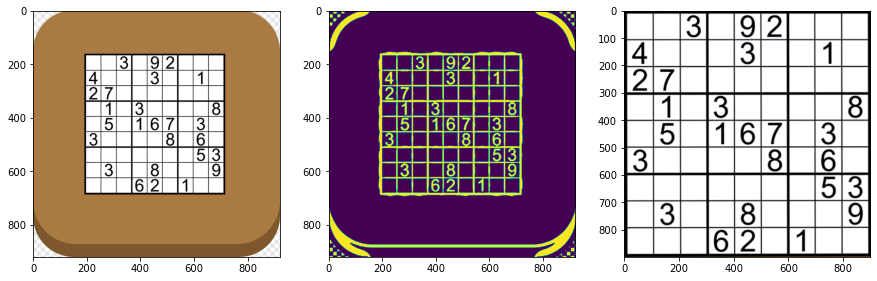

In [2]:
# Открываем изображение с судоку
img = cv2.imread('examples/16.png')

# Находим квадрат с судоку
blurry = cv2.GaussianBlur(img, (5, 5), 5)
gray = cv2.cvtColor(blurry, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,77,5)
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
grabs = imutils.grab_contours(cnts)
grabs = sorted(grabs, key=cv2.contourArea, reverse=True)
location = None
for grab in grabs:
    approx = cv2.approxPolyDP(grab, 15, True)
    if len(approx) == 4:
        rect = np.zeros((4, 2), dtype = "float32")
        cutt = approx[:,0]
        s = cutt.sum(axis = 1)
        
        # Сортировка углов по часовой стрелке
        rect[0] = cutt[np.argmin(s)]
        rect[2] = cutt[np.argmax(s)]
        diff = np.diff(cutt, axis = 1)
        rect[1] = cutt[np.argmin(diff)]
        rect[3] = cutt[np.argmax(diff)]
        location = rect
        break

height = 900
width = 900
pts1 = np.float32([location[0], location[1], location[3], location[2]])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Трансформируем перспективу
matrix = cv2.getPerspectiveTransform(pts1, pts2)
board = cv2.warpPerspective(img, matrix, (width, height))
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(thresh)
ax[2].imshow(board)

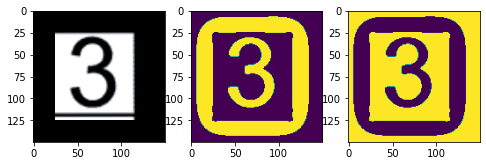

In [93]:
test = digs[6].copy()
test = cv2.copyMakeBorder(test, 25,25,25,25,cv2.BORDER_CONSTANT, (0,0,0))
grtest = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
bltest = cv2.GaussianBlur(grtest, (5,5), 5)
threshtest = cv2.adaptiveThreshold(bltest, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
kernel = cv2.getStructuringElement(shape=cv2.MORPH_ERODE, ksize=(5,5))
threshtest = cv2.morphologyEx(threshtest, cv2.MORPH_OPEN, kernel)
inv = 255 - threshtest
fig, ax = plt.subplots(1, 3, figsize=(8,8))
ax[0].imshow(test)
ax[1].imshow(threshtest)
ax[2].imshow(inv)

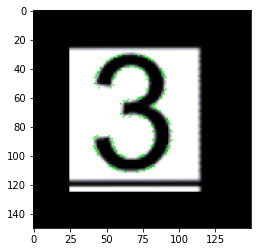

In [94]:
cnts = cv2.findContours(inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
grabbed = imutils.grab_contours(cnts)
spisok = sorted(grabbed, key=cv2.contourArea, reverse=True)
matr = np.zeros(inv.shape)
cv2.drawContours(test, spisok[-1], -1, (0,255,0))
plt.imshow(test)


In [95]:
cv2.drawContours(matr, spisok, -1, (255,255,255), -1)
rst = cv2.bitwise_and(test, matr)
plt.imshow(rst)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


,1,2,3,4,5,6,7,8,9
1,NaN,NaN,NaN,NaN,9,2,NaN,NaN,NaN
2,4,NaN,NaN,NaN,3,NaN,NaN,4,NaN
3,2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,NaN,3,NaN,NaN,NaN,NaN,8
5,NaN,5,NaN,1,6,7,NaN,3,NaN
6,13,NaN,NaN,NaN,NaN,8,NaN,6,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3
8,NaN,13,NaN,NaN,3,NaN,NaN,NaN,9
9,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN


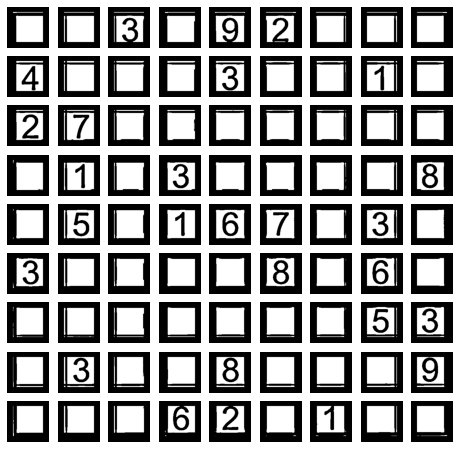

In [10]:
df_final = pd.DataFrame(index=range(1, 10), columns=range(1, 10))

fig, ax = plt.subplots(9, 9, figsize=(8,8))
split = np.split(board, 9, axis=1)
plmat = []
for col,j  in enumerate(split):
    digs = np.split(j, 9)
    for row,d in enumerate(digs):
        g = d.copy()
        e = g.copy()
        g = cv2.GaussianBlur(g, (5,5), 5)
        g = cv2.cvtColor(g, cv2.COLOR_BGR2GRAY)
        g = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 57, 5)
        cn = cv2.findContours(g, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        grs = imutils.grab_contours(cn)
        grs = sorted(grs, key=cv2.contourArea, reverse=True)
        
        msk = np.ones(e.shape, dtype=np.uint8)
        cv2.drawContours(msk, grs, -1, (255,255,255), -1)
        rst = cv2.bitwise_and((0,0,0), msk)
        rst[msk==1] = 255
        rst = cv2.copyMakeBorder(rst, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(0,0,0))
        ax[row][col].imshow(rst)
        ax[row][col].axis('off')
        text = pytesseract.image_to_string(rst, config='--psm 10 digits')
        plmat.append([text, str(row+1), str(col+1)])
        df_final.iloc[row, col] = text

        
        
df_final.fillna('', inplace=True)
df_final = df_final.applymap(lambda x: x[:x.find('\n')])
df_final = df_final.applymap(lambda x: ''.join(re.findall('[1-9]', x)))
df_final = df_final[~(df_final=='')]

df_final

## Pulp

In [4]:
nums = [*map(str, [*range(1,10)])] # список чисел от 1 до 9 со строковым типом
rows = nums
cols = nums
vals = nums

choices = LpVariable.dicts("Choice", (vals, rows, cols), 0, 1, LpInteger)

In [5]:
prob = LpProblem("Судоку", LpMaximize)
prob += 0, "Целевая функция" # Задаётся нулём, так как нас интересует только подбор значения согласно ограничениям

In [6]:
for r, c in product(rows, cols):
    prob += lpSum([choices[v][r][c] for v in vals]) == 1, ""

for v, r in product(vals, rows):
    prob += lpSum([choices[v][r][c] for c in cols]) == 1, ""

for v, c in product(vals, cols):
    prob += lpSum([choices[v][r][c] for r in rows]) == 1, ""

In [7]:
grid = range(3)
subs = [[(rows[3*i+k],cols[3*j+l]) for k,l in product(grid, grid)] for i,j in product(grid, grid)]

for v,s in product(vals, subs):
    prob += lpSum([choices[v][r][c] for (r, c) in s]) == 1, ""

In [8]:
for i in plmat:
    i[0] = ''.join(re.findall('[\d]', i[0]))

sudoku_map = plmat.copy()
for i in plmat:
    if i[0] == '':
        sudoku_map.remove(i)
        
for num in sudoku_map:
    prob += choices[num[0]][num[1]][num[2]] == 1, ""

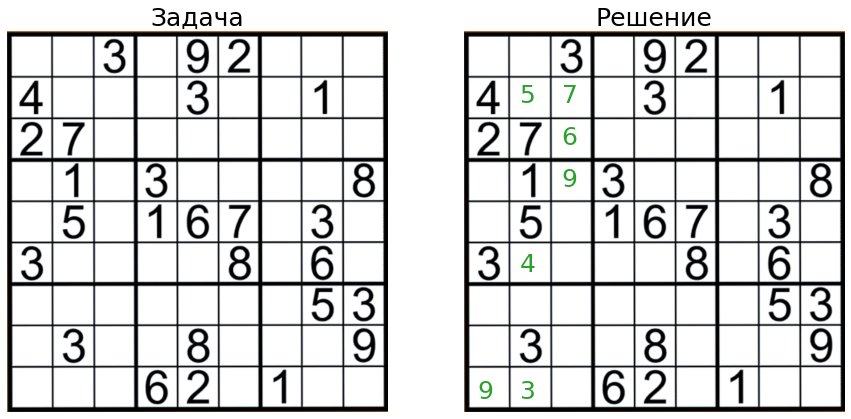

In [9]:
prob.solve()

fig, axes = plt.subplots(1,2, figsize=(15,15))
axes[0].imshow(board)
axes[0].set_title('Задача', fontsize=25)
axes[1].imshow(board)
axes[1].set_title('Решение', fontsize=25)
for a in axes:
    a.axis('off')

y = 50
for r in rows:
    x = 50
    for c,v in product(cols, vals):
        if choices[v][r][c].value() == 1:
            if [v,r,c] not in sudoku_map:
                axes[1].text(x,y,v, ha='center', va='center', fontsize=25, color='tab:green')
            x += 100
    y += 100
